In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial

%matplotlib inline


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [3]:
# 2. Підготовка даних
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
])

root_dir = 'Intelligent-Computation/Lab3/cifar10' 

full_train = datasets.CIFAR10(root=root_dir, train=True, download=False, transform=train_transform)
test_set = datasets.CIFAR10(root=root_dir, train=False, download=False, transform=test_transform)


val_ratio = 0.2
val_size = int(len(full_train) * val_ratio)
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size])

batch_size = 64
data_loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
}

In [4]:
classes = full_train.classes  # Правильно


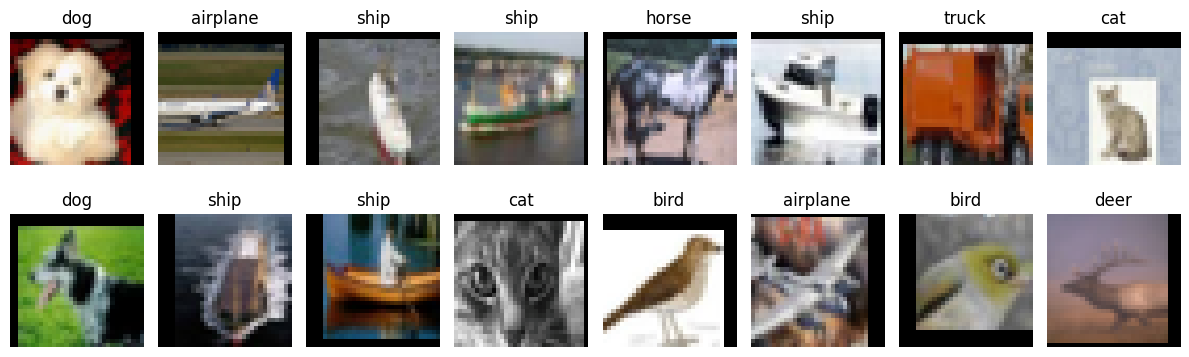

In [5]:
# 3. Візуалізація
mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1)
std = torch.tensor((0.2470, 0.2435, 0.2616)).view(3,1,1)
images, labels = next(iter(data_loaders['train']))
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i in range(16):
    img = images[i] * std + mean
    img = img.permute(1, 2, 0).numpy()
    ax = axes[i//8, i%8]
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(classes[labels[i]])
    ax.axis('off')
plt.tight_layout()

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, features_channels=None, additional_block=False, activation=nn.ReLU, conv_dropout=0.0):
        super(SimpleCNN, self).__init__()
        if features_channels is None:
            features_channels = [32, 64, 128]
        layers = []
        in_ch = 3
        for out_ch in features_channels:
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(activation())
            if conv_dropout > 0:
                layers.append(nn.Dropout2d(conv_dropout))
            layers.append(nn.MaxPool2d(2))
            in_ch = out_ch
        if additional_block:
            layers.extend([
                nn.Conv2d(in_ch, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                activation(),
                nn.MaxPool2d(2)
            ])
            in_ch = 256
        self.features = nn.Sequential(*layers)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_ch, 256),
            activation(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        return self.classifier(x)

In [7]:
# 5. Функції тренування

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    return total_loss / total, correct / total

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return total_loss / total, correct / total

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
# 6. Експерименти
model_fns = {
    'baseline': SimpleCNN,
    'exp1': lambda: SimpleCNN(features_channels=[64,128,256]),
    'exp2': lambda: SimpleCNN(additional_block=True),
    'exp3': lambda: SimpleCNN(activation=nn.LeakyReLU),
    'exp4': lambda: SimpleCNN(conv_dropout=0.3)
}

criterion = nn.CrossEntropyLoss()
results = []
num_epochs = 20

for name, fn in model_fns.items():
    model = fn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    best_val_acc = 0
    best_state = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start = time()

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, data_loaders['train'], criterion, optimizer)
        val_loss, val_acc = validate(model, data_loaders['val'], criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"{name} | Epoch {epoch+1}/{num_epochs}: TL={train_loss:.4f}, TA={train_acc:.4f}, VL={val_loss:.4f}, VA={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    duration = time() - start
    model.load_state_dict(best_state)
    test_loss, test_acc = validate(model, data_loaders['test'], criterion)

    results.append({
        'model': name,
        'params': count_parameters(model),
        'test_acc': test_acc,
        'val_acc': best_val_acc,
        'time_s': duration,
        'history': history
    })

baseline | Epoch 1/20: TL=1.5254, TA=0.4369, VL=1.3544, VA=0.5070
baseline | Epoch 2/20: TL=1.2108, TA=0.5653, VL=1.2188, VA=0.5628
baseline | Epoch 3/20: TL=1.0920, TA=0.6066, VL=1.0998, VA=0.5964
baseline | Epoch 4/20: TL=1.0169, TA=0.6298, VL=0.9737, VA=0.6482
baseline | Epoch 5/20: TL=0.9601, TA=0.6574, VL=0.9530, VA=0.6543
baseline | Epoch 6/20: TL=0.9104, TA=0.6754, VL=0.9736, VA=0.6481
baseline | Epoch 7/20: TL=0.8706, TA=0.6890, VL=0.9190, VA=0.6733
baseline | Epoch 8/20: TL=0.8381, TA=0.7021, VL=0.9190, VA=0.6723
baseline | Epoch 9/20: TL=0.8098, TA=0.7151, VL=0.8521, VA=0.6914
baseline | Epoch 10/20: TL=0.7834, TA=0.7208, VL=0.8744, VA=0.6945
baseline | Epoch 11/20: TL=0.7557, TA=0.7321, VL=0.8149, VA=0.7144
baseline | Epoch 12/20: TL=0.7396, TA=0.7365, VL=0.7865, VA=0.7240
baseline | Epoch 13/20: TL=0.7188, TA=0.7459, VL=0.7471, VA=0.7359
baseline | Epoch 14/20: TL=0.6975, TA=0.7510, VL=0.8021, VA=0.7174
baseline | Epoch 15/20: TL=0.6788, TA=0.7591, VL=0.8049, VA=0.7196
base

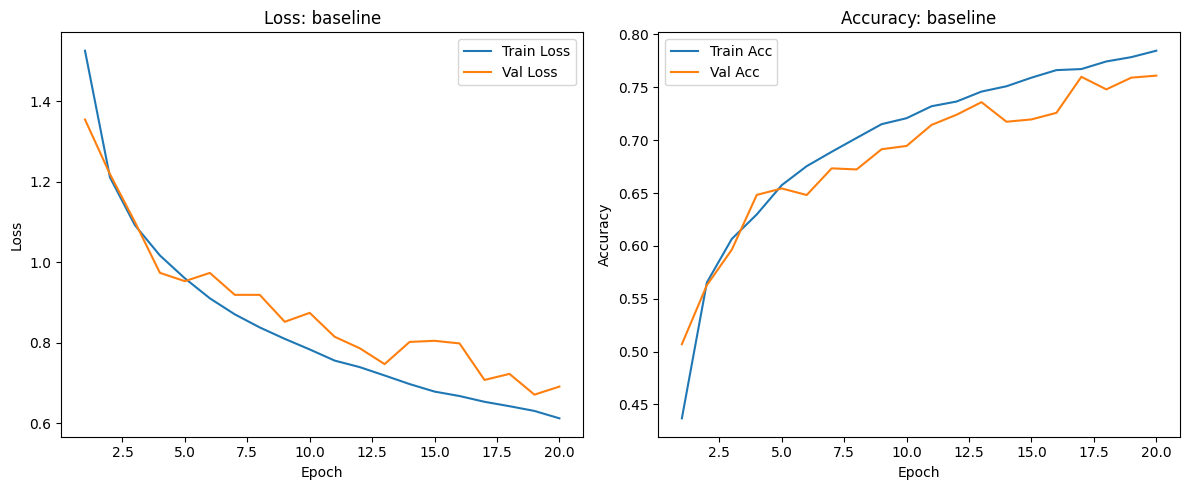

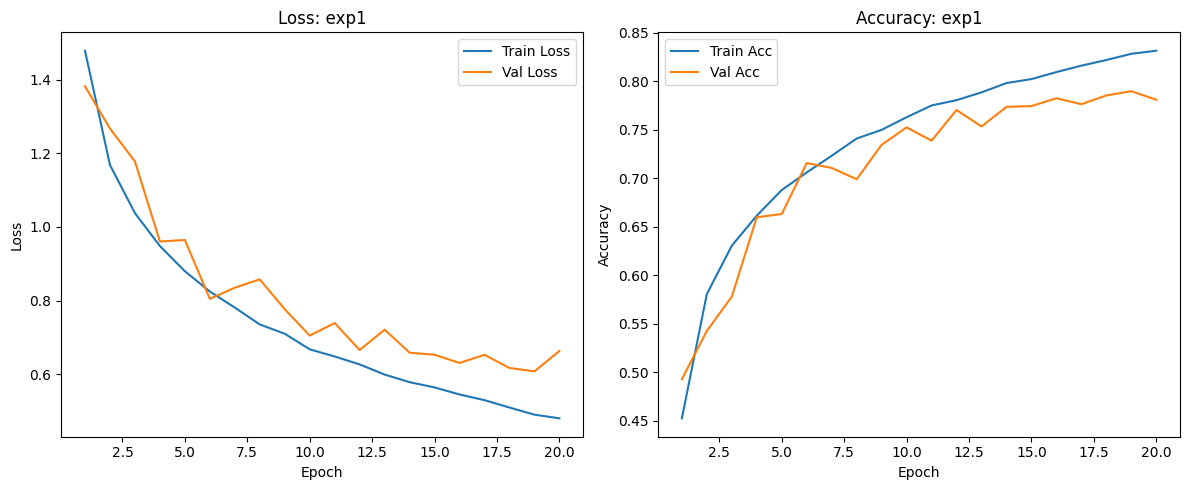

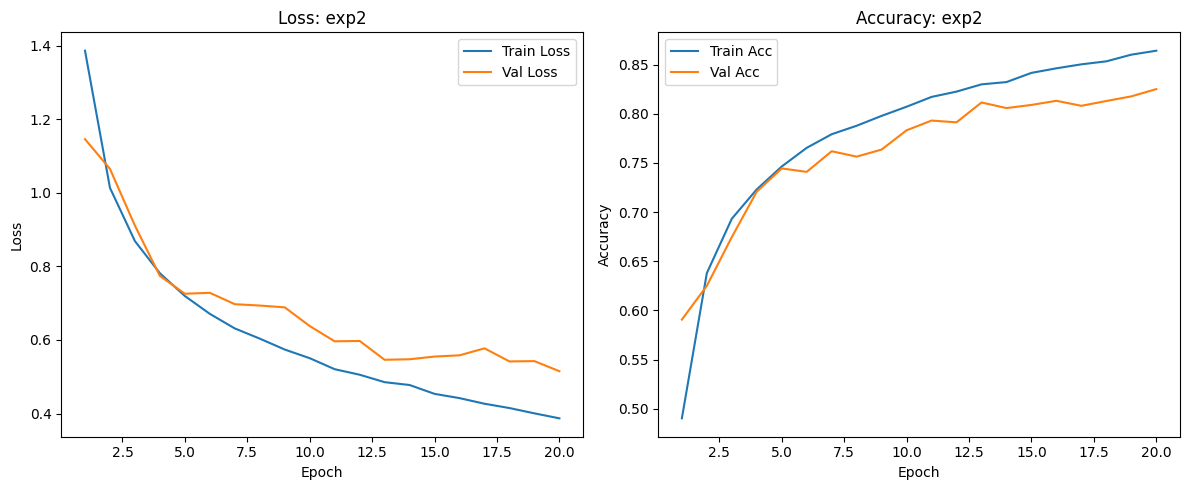

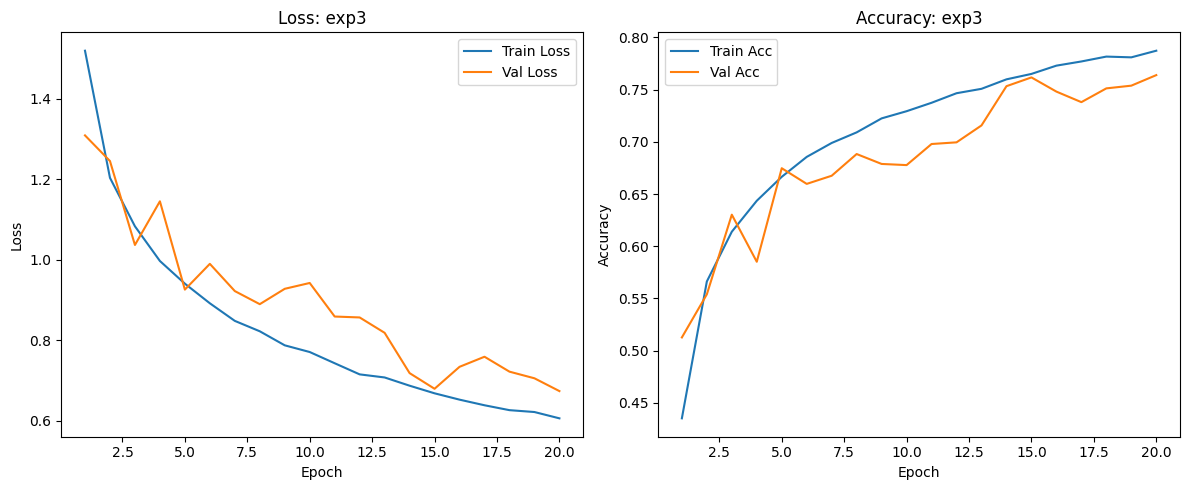

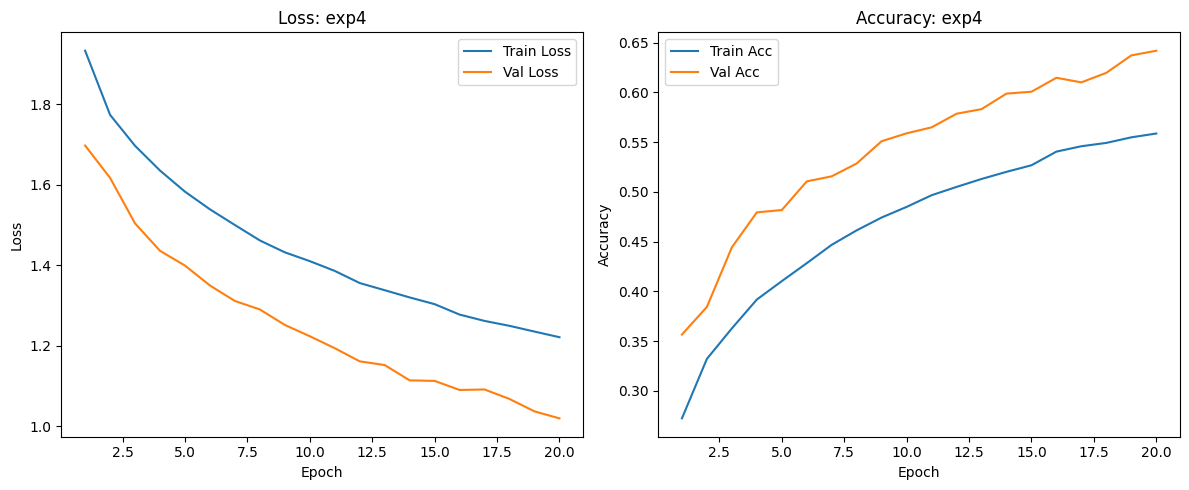

In [12]:
# 7. Графіки

def plot_metrics(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'Loss: {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f'Accuracy: {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

for result in results:
    plot_metrics(result['history'], result['model'])

In [13]:
# 8. Підсумкова таблиця
import pandas as pd
summary = pd.DataFrame([{k: v for k, v in r.items() if k != 'history'} for r in results])
print(summary.sort_values(by='test_acc', ascending=False))

      model  params  test_acc  val_acc      time_s
2      exp2  457738    0.8304   0.8251  382.242215
1      exp1  440074    0.7778   0.7896  393.056908
3      exp3  129290    0.7486   0.7639  378.224347
0  baseline  129290    0.7419   0.7610  408.236129
4      exp4  129290    0.6406   0.6419  367.642336
